# Estimator validation

This notebook contains code to generate Figure 2 of the paper. 

This notebook also serves to compare the estimates of the re-implemented scmemo with sceb package from Vasilis. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [256]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)


In [4]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [5]:
import sys
sys.path.append('/home/ssm-user/Github/single_cell_eb/')
sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb')
import scdd

ModuleNotFoundError: No module named 'scdd'

In [301]:
figpath = '/data/home/Github/scrna-parameter-estimation/figures/fig2/'

### Check 1D estimates of `sceb` with `scmemo`

Using the Poisson model. The outputs should be identical, this is for checking the implementation. 

In [6]:
data = sp.sparse.csr_matrix(simulate.simulate_transcriptomes(100, 20))
adata = sc.AnnData(data)
size_factors = scdd.dd_size_factor(adata)

In [7]:
_, M_dd = scdd.dd_1d_moment(adata, size_factor=size_factors)
var_scdd = scdd.M_to_var(M_dd)
print(var_scdd)

#time start: 0.0s
n_cell=100, n_gene=20
#total: 0.00s
[9.86033717e-01 1.33283156e+02 2.19394150e+01 2.00407875e-01
 1.63151208e+00 5.71789015e+01 1.75522015e+01 1.19555327e+02
 2.79488530e+01 5.87060454e+01 1.09103434e+03 6.39514505e+01
 1.00000000e-18 1.49307703e+02 1.02608010e+00 1.94851387e+01
 5.42329186e+01 1.36474770e+01 4.94848485e+02 8.07406378e+02]


In [8]:
imp.reload(estimator)
mean_scmemo, var_scmemo = estimator._poisson_1d(data, data.shape[0], size_factors)
print(var_scmemo)

[9.86033649e-01 1.33283208e+02 2.19394289e+01 2.00407903e-01
 1.63151196e+00 5.71789049e+01 1.75521965e+01 1.19555327e+02
 2.79488875e+01 5.87059892e+01 1.09103476e+03 6.39514931e+01
 0.00000000e+00 1.49307677e+02 1.02607943e+00 1.94851396e+01
 5.42329444e+01 1.36474728e+01 4.94847546e+02 8.07434038e+02]


In [9]:
df = pd.DataFrame()
df['size_factor'] = size_factors
df['inv_size_factor'] = 1/size_factors
df['inv_size_factor_sq'] = 1/size_factors**2
df['expr'] = data[:, 0].todense().A1
precomputed_size_factors = df.groupby('expr')['inv_size_factor'].mean(), df.groupby('expr')['inv_size_factor_sq'].mean()

In [10]:
imp.reload(estimator)
expr, count = np.unique(data[:, 0].todense().A1, return_counts=True)
print(estimator._poisson_1d((expr, count), data.shape[0], precomputed_size_factors))

[0.5217290008068085, 0.9860336223993191]


### Check 2D estimates of `sceb` and `scmemo`

Using the Poisson model. The outputs should be identical, this is for checking the implementation. 

In [11]:
data = sp.sparse.csr_matrix(simulate.simulate_transcriptomes(1000, 4))
adata = sc.AnnData(data)
size_factors = scdd.dd_size_factor(adata)

In [12]:
mean_scdd, cov_scdd, corr_scdd = scdd.dd_covariance(adata, size_factors)
print(cov_scdd)

[[  9.66801891  -1.45902975  -1.97166503 -10.13305759]
 [ -1.45902975   3.37530982  -0.83509601  -2.76389597]
 [ -1.97166503  -0.83509601   2.51976446  -2.9553916 ]
 [-10.13305759  -2.76389597  -2.9553916    1.48619472]]


/home/ssm-user/Github/single_cell_eb/sceb/scdd.py:237: RuntimeWarning: divide by zero encountered in true_divide
  row_weight = 1/size_factor


In [13]:
imp.reload(estimator)
cov_scmemo = estimator._poisson_cov(data, data.shape[0], size_factors, idx1=[0, 1, 2], idx2=[1, 2, 3])
print(cov_scmemo)

[[ -1.45902975  -1.97166503 -10.13305759]
 [  3.37530982  -0.83509601  -2.76389597]
 [ -0.83509601   2.51976446  -2.9553916 ]]


/home/ssm-user/Github/scrna-parameter-estimation/scmemo/estimator.py:122: RuntimeWarning: divide by zero encountered in true_divide
  row_weight = (1/size_factor).reshape([1, -1]) if size_factor is not None else np.ones(data.shape[0]).reshape([1, -1])


In [14]:
expr, count = np.unique(data[:, :2].toarray(), return_counts=True, axis=0)

df = pd.DataFrame()
df['size_factor'] = size_factors
df['inv_size_factor'] = 1/size_factors
df['inv_size_factor_sq'] = 1/size_factors**2
df['expr1'] = data[:, 0].todense().A1
df['expr2'] = data[:, 1].todense().A1

precomputed_size_factors = df.groupby(['expr1', 'expr2'])['inv_size_factor'].mean(), df.groupby(['expr1', 'expr2'])['inv_size_factor_sq'].mean()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [15]:
cov_scmemo = estimator._poisson_cov((expr[:, 0], expr[:, 1], count), data.shape[0], size_factor=precomputed_size_factors)
print(cov_scmemo)

-1.4590297282462616


### Variance/correlation estimation while varying q_sq

In [32]:
q = 0.1
q_sq_list = [q**2+1e-8, 0.0105, 0.011]#[0.07**2+1e-6, 0.005, 0.006]

In [33]:
import warnings
# warnings.filterwarnings("ignore")


In [34]:
imp.reload(simulate)

true_data = simulate.simulate_transcriptomes(5000, 10000, correlated=False)
true_relative_data = true_data / true_data.sum(axis=1).reshape(-1, 1)

0.1088
0.1162
0.1177


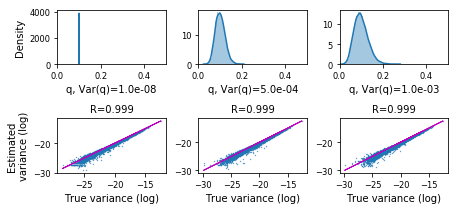

In [35]:
plt.figure(figsize=(7, 3))
plt.subplots_adjust(hspace=1, wspace=0.3)
num_subplot_col = len(q_sq_list)
num_subplot_row = 2

for col_num, q_sq in enumerate(q_sq_list):
    
    qs, captured_data = simulate.capture_sampling(true_data, q, q_sq)
    Nr = captured_data.sum(axis=1).mean()
    captured_relative_data = captured_data/captured_data.sum(axis=1).reshape(-1, 1)
    adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
    
    x_true, y_true = true_relative_data.mean(axis=0), true_relative_data.var(axis=0)
    x_obs, y_obs = captured_relative_data.mean(axis=0), captured_relative_data.var(axis=0)
    
    _, M_dd = scdd.dd_1d_moment(adata, size_factor=scdd.dd_size_factor(adata), verbose=False, Nr=Nr)
    var_scdd = scdd.M_to_var(M_dd)
    
#     obs_cell_sizes = captured_data.sum(axis=1).reshape(-1, 1)
#     mm_var = ((captured_data**2 - (1-0.1)*captured_data)/(obs_cell_sizes**2-obs_cell_sizes)).mean(axis=0) - (captured_data/obs_cell_sizes).mean(axis=0)**2
    
#     var_scdd = mm_var
    
    condition = np.log(var_scdd) > -30
    
#     true_corrs = np.corrcoef(true_data, rowvar=False).ravel()
#     estimated_corrs = corr_scdd.ravel()
#     corr_cond = np.isfinite(estimated_corrs)
#     true_corrs = true_corrs[corr_cond]
#     estimated_corrs = estimated_corrs[corr_cond]
        
    plt.subplot(num_subplot_row, num_subplot_col, col_num+1)
    sns.distplot(qs)
    plt.xlabel('q, Var(q)={:.1e}'.format(q_sq-q**2))
    plt.xlim(0, 0.5)
    if col_num == 0:
        plt.ylabel('Density')
        
    plt.subplot(num_subplot_row, num_subplot_col, col_num+1+num_subplot_col)
    plt.plot(np.log(y_true[condition]), np.log(y_true[condition]), color='m', lw=1)
    plt.scatter(np.log(y_true[condition]), np.log(var_scdd[condition]), s=0.1)
    plt.xlabel('True variance (log)');
    if col_num == 0:
        plt.ylabel('Estimated\nvariance (log)')
    plt.title('R={:.3f}'.format(stats.pearsonr(var_scdd[condition], y_true[condition])[0]))
    print((var_scdd>y_true).mean())
plt.savefig(figpath + 'variance_q_sq_robust.png', bbox_inches='tight')

### Estimation of moments from arbitrary underyling true distributions

In [36]:
# Generate cell sizes
cell_sizes = np.exp(stats.norm.rvs(11, 0.01, 20000)).astype(int)

# Generate true expression of a single gene
expr_1 = np.exp(stats.norm.rvs(6, 0.08, 12000)).astype(int)
# expr = expr_1
expr_2 = stats.norm.rvs(450, 10, 8000).astype(int)
expr = np.concatenate([expr_1, expr_2])

# Generate the q's
q = 0.1
q_sq = 0.011
m = q
v = q_sq - q**2
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)
qs = stats.beta.rvs(alpha, beta, size=20000)

# Generate the observed distribution
obs_expr = stats.hypergeom.rvs(M=cell_sizes, n=expr, N=(qs*cell_sizes).astype(int))
obs_cell_sizes = (qs*cell_sizes).astype(int)

# Calculate relative abundances
rel_obs_expr = obs_expr/obs_cell_sizes
rel_expr = expr/cell_sizes

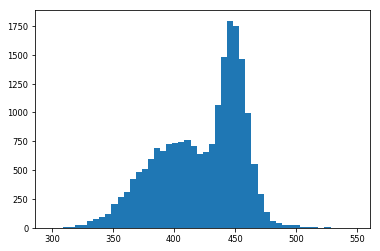

In [37]:
plt.hist(expr, bins=50);

In [38]:
# method of moments estimator
mm_var = ((obs_expr**2 - obs_expr)/(obs_cell_sizes**2-obs_cell_sizes)).mean() - (obs_expr/obs_cell_sizes).mean()**2

mm_std = np.sqrt(mm_var)
print(mm_std, rel_expr.std())

0.000475220156155731 0.0005757378200670278


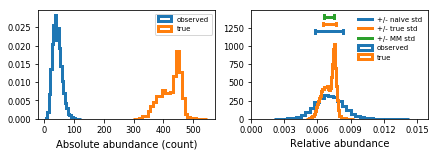

In [39]:
plt.figure(figsize=(7, 2))
plt.subplot(1, 2, 1)
plt.hist(obs_expr, density=True, bins=24, histtype='step', lw=3);
plt.hist(expr, density=True, bins=26, histtype='step', lw=3);
plt.legend(['observed', 'true'])
plt.xlabel('Absolute abundance (count)')
# plt.ylim(0, 0.5)

plt.subplot(1, 2, 2);
plt.hist(rel_obs_expr, label='observed', density=True, bins=30, histtype='step', lw=3)
plt.hist(rel_expr, label='true', density=True, bins=50, histtype='step', lw=3)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.003))
plt.xlabel('Relative abundance')
plt.legend()
# plt.ylim(0, 600)
plt.xlim(0, 0.016)

add = 800

# Plot the naive variance calculation
plt.plot([rel_expr.mean() - rel_obs_expr.std(), rel_expr.mean() + rel_obs_expr.std()], [add + 400,add +  400], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], lw=3, label='+/- naive std')
plt.plot([rel_expr.mean() - rel_obs_expr.std(), rel_expr.mean() - rel_obs_expr.std()], [add + 380, add + 420], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], lw=3)
plt.plot([rel_expr.mean() + rel_obs_expr.std(), rel_expr.mean() + rel_obs_expr.std()], [add + 380, add + 420], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], lw=3)

# Plot the true variance calculation
plt.plot([rel_expr.mean() - rel_expr.std(), rel_expr.mean() + rel_expr.std()], [add + 470 + 30, add + 470+ 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], lw=3, label='+/- true std')
plt.plot([rel_expr.mean() - rel_expr.std(), rel_expr.mean() - rel_expr.std()], [add + 450+ 30, add + 490+ 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], lw=3)
plt.plot([rel_expr.mean() + rel_expr.std(), rel_expr.mean() + rel_expr.std()], [add + 450+ 30, add + 490+ 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], lw=3)

# MM estimate
plt.plot([rel_expr.mean() - mm_std, rel_expr.mean() + mm_std], [add + 540+ 30 + 30, add + 540+ 30 + 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], lw=3, label='+/- MM std')
plt.plot([rel_expr.mean() - mm_std, rel_expr.mean() - mm_std], [add + 520+ 30 + 30, add + 560+ 30 + 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], lw=3)
plt.plot([rel_expr.mean() + mm_std, rel_expr.mean() + mm_std], [add + 520+ 30 + 30, add + 560+ 30 + 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], lw=3)

plt.legend(frameon=False)
plt.savefig(figpath + 'variance_estimation.pdf', bbox_inches='tight')

### Poisson vs hypergeometric

In [ ]:
_poisson_1d(data, n_obs, size_factor=None, n_umi=1):

In [37]:
imp.reload(estimator)

<module 'estimator' from '/data/home/Github/scrna-parameter-estimation/scmemo/estimator.py'>

In [110]:
np.nanmin(corr_hyp)

-2.5169529914855957

(array([218., 499., 154.,  61.,  35.,  13.,   6.,   6.,   5.,   3.]),
 array([1452.7 , 1544.27, 1635.84, 1727.41, 1818.98, 1910.55, 2002.12,
        2093.69, 2185.26, 2276.83, 2368.4 ]),
 <a list of 10 Patch objects>)

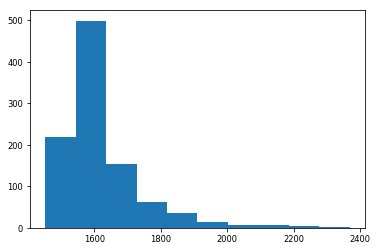

In [143]:
plt.hist(true_data.sum(axis=1)/10)

In [259]:
0.011-0.01

0.0009999999999999992

In [316]:
def compare_esimators(q, plot=False, true_data=None, var_q=1e-10):
    
    q_sq = var_q + q**2
    
    true_data = simulate.simulate_transcriptomes(1000, 1000, correlated=True) if true_data is None else true_data
    true_relative_data = true_data / true_data.sum(axis=1).reshape(-1, 1)

    qs, captured_data = simulate.capture_sampling(true_data, q, q_sq)
    Nr = captured_data.sum(axis=1).mean()
    captured_relative_data = captured_data/captured_data.sum(axis=1).reshape(-1, 1)
    adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
    sf = estimator._estimate_size_factor(adata.X)

    good_idx = (captured_data.mean(axis=0) > q)

    # True moments
    m_true, v_true, corr_true = true_relative_data.mean(axis=0), true_relative_data.var(axis=0), np.corrcoef(true_relative_data, rowvar=False)

    # Compute 1D moments
    m_obs, v_obs = captured_relative_data.mean(axis=0), captured_relative_data.var(axis=0)
    m_poi, v_poi = estimator._poisson_1d(adata.X, size_factor=sf, n_obs=true_data.shape[0])
    m_hyp, v_hyp = estimator._hyper_1d(adata.X, size_factor=sf, n_obs=true_data.shape[0], q=q)

    # Compute 2D moments
    corr_obs = np.corrcoef(captured_relative_data, rowvar=False)
    cov_poi = estimator._poisson_cov(adata.X, n_obs=true_data.shape[0], size_factor=sf, idx1=None, idx2=None)
    cov_hyp = estimator._hyper_cov(adata.X, n_obs=true_data.shape[0], size_factor=sf, idx1=None, idx2=None, q=q)
    corr_poi = estimator._corr_from_cov(cov_poi, v_poi, v_poi)
    corr_hyp = estimator._corr_from_cov(cov_hyp, v_hyp, v_hyp)

    corr_poi[np.abs(corr_poi) > 1] = np.nan
    corr_hyp[np.abs(corr_hyp) > 1] = np.nan

    mean_list = [m_obs, m_poi, m_hyp]
    var_list = [v_obs, v_poi, v_hyp]
    corr_list = [corr_obs, corr_poi, corr_hyp]
    estimated_list = [mean_list, var_list, corr_list]
    true_list = [m_true, v_true, corr_true]

    if plot:
        count = 0
        for j in range(3):
            for i in range(3):

                plt.subplot(3, 3, count+1)


                if i != 2:
                    plt.scatter(
                        np.log(true_list[i][good_idx]),
                        np.log(estimated_list[i][j][good_idx]),
                        s=0.3)
                    plt.plot(np.log(true_list[i][good_idx]), np.log(true_list[i][good_idx]), linestyle='--', color='m')
                    plt.xlim(np.log(true_list[i][good_idx]).min(), np.log(true_list[i][good_idx]).max())
                    plt.ylim(np.log(true_list[i][good_idx]).min(), np.log(true_list[i][good_idx]).max())

                else:

                    x = true_list[i][good_idx, :][:, good_idx].ravel()
                    y = estimated_list[i][j][good_idx, :][:, good_idx].ravel()

                    sample_idx = np.random.choice(x.shape[0], 100000)

                    plt.scatter(
                        x[sample_idx],
                        y[sample_idx],
                        s=0.3)
                    plt.plot([-1, 1], [-1, 1],linestyle='--', color='m')
                    plt.xlim(-1, 1);
                    plt.ylim(-1, 1);
                    
                if i != 0:
                    plt.yticks([])
                    
                if i == 1 or i == 0:
                    
                    print((np.log(true_list[i][good_idx]) > np.log(estimated_list[i][j][good_idx])).mean())

                count += 1
    else:
        return qs, good_idx, estimated_list, true_list

/data/home/Github/scrna-parameter-estimation/scmemo/estimator.py:204: RuntimeWarning: invalid value encountered in less_equal
  var_2[var_2 <= 0] = np.nan
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater


0.5124087591240876
0.013138686131386862
0.5124087591240876
0.9985401459854014
0.5124087591240876
0.5299270072992701


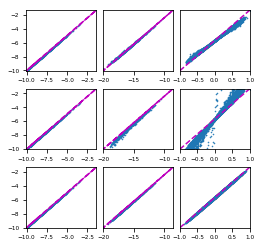

In [312]:
q = 0.6
plt.figure(figsize=(4, 4))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
true_data = simulate.simulate_transcriptomes(5000, 1000, correlated=True)
compare_esimators(q, plot=True, true_data=true_data)
plt.savefig(figpath + 'poi_vs_hyper_scatter_2.png', bbox_inches='tight')

/data/home/Github/scrna-parameter-estimation/scmemo/estimator.py:204: RuntimeWarning: invalid value encountered in less_equal
  var_2[var_2 <= 0] = np.nan
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater


0.510548523206751
0.0
0.510548523206751
0.9479606188466948
0.510548523206751
0.5133614627285513


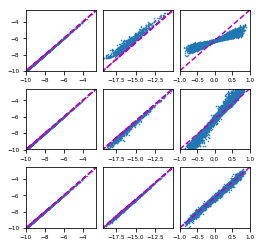

In [313]:
q = 0.1
plt.figure(figsize=(4, 4))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
true_data = simulate.simulate_transcriptomes(5000, 1000, correlated=True)
compare_esimators(q, plot=True, true_data=true_data)
plt.savefig(figpath + 'poi_vs_hyper_scatter_1.png', bbox_inches='tight')

0.472992700729927
0.0072992700729927005
0.472992700729927
0.997080291970803
0.472992700729927
0.5065693430656935


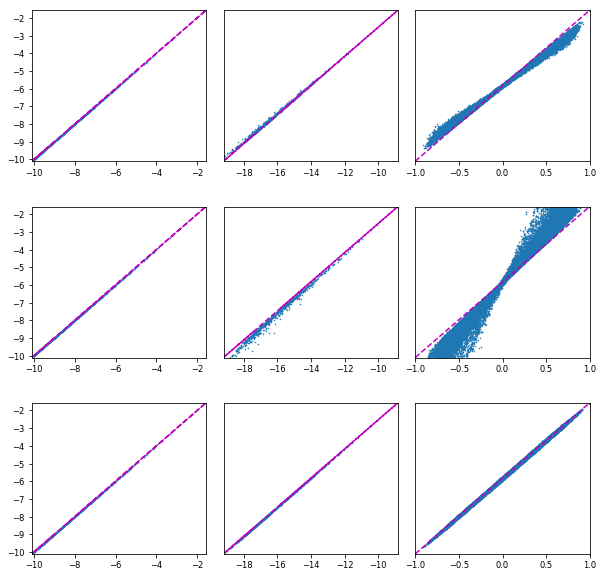

In [318]:
q = 0.6
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
true_data = simulate.simulate_transcriptomes(5000, 1000, correlated=True)
compare_esimators(q, plot=True, true_data=true_data)
# plt.savefig(figpath + 'poi_vs_hyper_scatter_1.png', bbox_inches='tight')

In [289]:
def compute_mse(x, y, log=True):
    
    if log:
        return np.nanmean(np.abs(np.log(x)-np.log(y)))
    else:
        return np.nanmean(np.abs(x-y))
    
m_mse_list, v_mse_list, c_mse_list = [], [], []
true_data = simulate.simulate_transcriptomes(5000, 1000, correlated=True)
q_list = [0.1, 0.15, 0.3, 0.5, 0.7, 0.99]
qs_list = []
for q in q_list:
    qs, good_idx, est, true = compare_esimators(q, plot=False, true_data=true_data)
    qs_list.append(qs)
    m_mse_list.append([compute_mse(x[good_idx], true[0][good_idx]) for x in est[0]])
    v_mse_list.append([compute_mse(x[good_idx], true[1][good_idx])  for x in est[1]])
    c_mse_list.append([compute_mse(x[good_idx, :][:, good_idx], true[2][good_idx, :][:, good_idx], log=False) for x in est[2]])
    
m_mse_list, v_mse_list, c_mse_list = np.array(m_mse_list), np.array(v_mse_list), np.array(c_mse_list)

/data/home/Github/scrna-parameter-estimation/scmemo/estimator.py:204: RuntimeWarning: invalid value encountered in less_equal
  if type(cov) != np.ndarray:
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/data/home/Github/scrna-parameter-estimation/scmemo/estimator.py:204: RuntimeWarning: invalid value encountered in less_equal
  if type(cov) != np.ndarray:
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/data/home/Github/scrna-parameter-estimation/scmemo/estimator.py:204: RuntimeWarning: invalid value encountered in less_equal
  if type(cov) != np.ndarray:
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/data/home/Github/scrna-parameter-estimation/scmemo/estimator.py:204: RuntimeWarning: invalid val

Text(0.5, 0, 'overall UMI efficiency (q)')

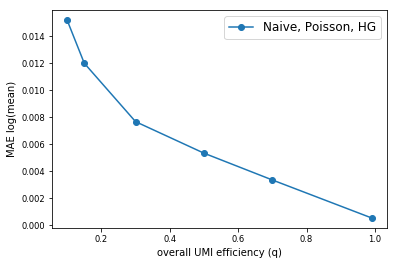

In [321]:
# plt.subplot(1, 2, 1)
plt.plot(q_list, m_mse_list[:, 0], '-o')
plt.legend(['Naive, Poisson, HG'])
plt.ylabel('MAE log(mean)')
plt.xlabel('overall UMI efficiency (q)')

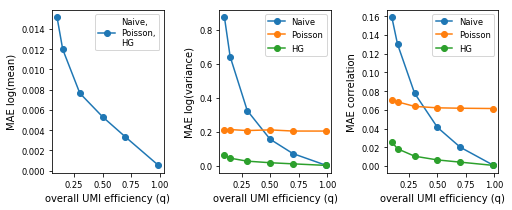

In [325]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

plt.figure(figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 3, 1)
plt.plot(q_list, m_mse_list[:, 0], '-o')
plt.legend(['Naive,\nPoisson,\nHG'])
plt.ylabel('MAE log(mean)')
plt.xlabel('overall UMI efficiency (q)')

plt.subplot(1, 3, 2)
plt.plot(q_list, v_mse_list[:, 0], '-o')
plt.plot(q_list, v_mse_list[:, 1], '-o')
plt.plot(q_list, v_mse_list[:, 2], '-o')
plt.legend(['Naive', 'Poisson', 'HG'])
plt.ylabel('MAE log(variance)')
plt.xlabel('overall UMI efficiency (q)')

plt.subplot(1, 3, 3)
plt.plot(q_list, c_mse_list[:, 0], '-o')
plt.plot(q_list, c_mse_list[:, 1], '-o')
plt.plot(q_list, c_mse_list[:, 2], '-o')
plt.legend(['Naive', 'Poisson', 'HG'])
plt.ylabel('MAE correlation')
plt.xlabel('overall UMI efficiency (q)')

plt.savefig(figpath + 'poi_vs_hyper_mae.pdf', bbox_inches='tight')

In [202]:
mean_mse


[5.364642707455465e-09, 5.364654855995396e-09, 5.364654855995396e-09]

In [203]:
var_mse

[7.853489974420156e-10, 1.6696770355758506e-12, 5.253330915139939e-12]

In [204]:
corr_mse

[0.07155027969271335, 0.14214224008649465, 0.20052082769521437]